Installing stable-baselines3...
Installation complete.


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


--- RUNNING SINGLE-AGENT EXPERIMENT (Figures 1, 4, 6) ---

--- Training agent for N=1 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: 
datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects 
to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Training complete.


/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


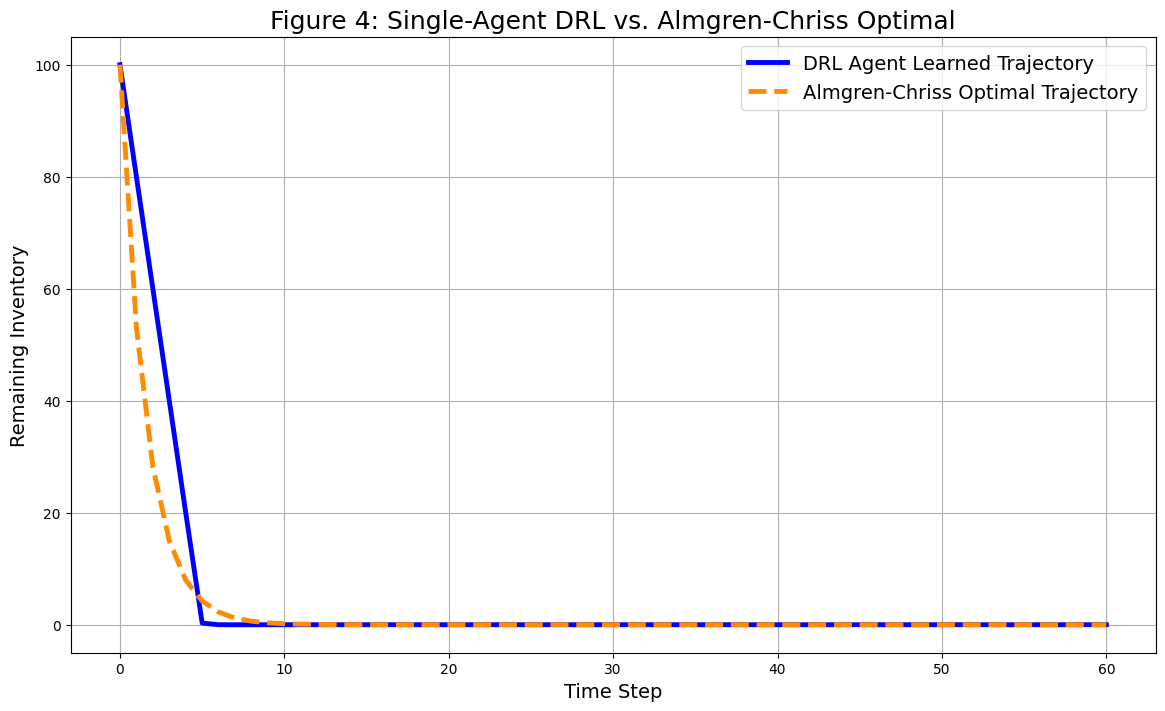


--- Simulating Volatile Day Scenario for Figure 1 ---


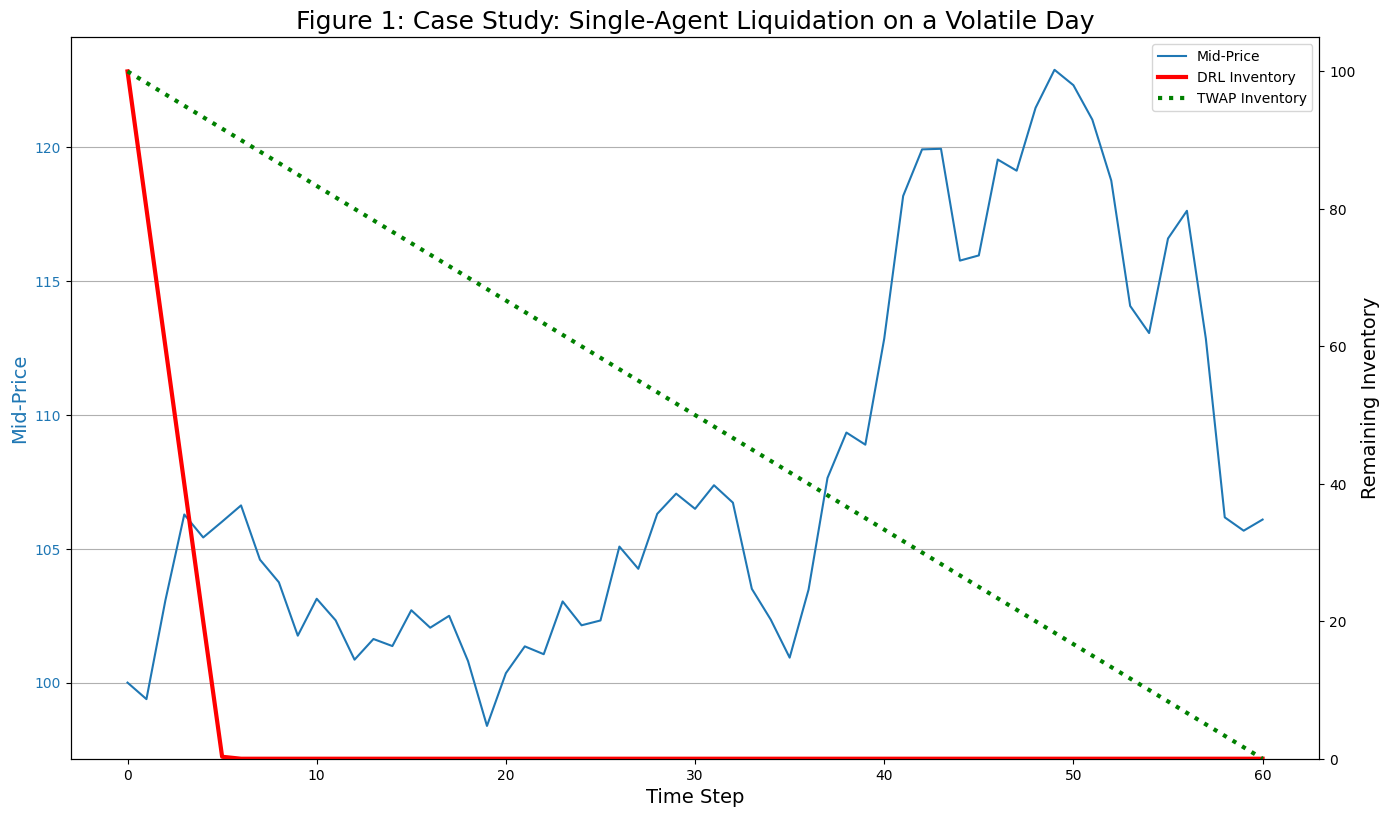


--- Analyzing Execution Cost Distribution for Figure 6 ---


Simulating episodes for cost analysis: 100%|██████████| 500/500 [00:12<00:00, 40.05it/s]


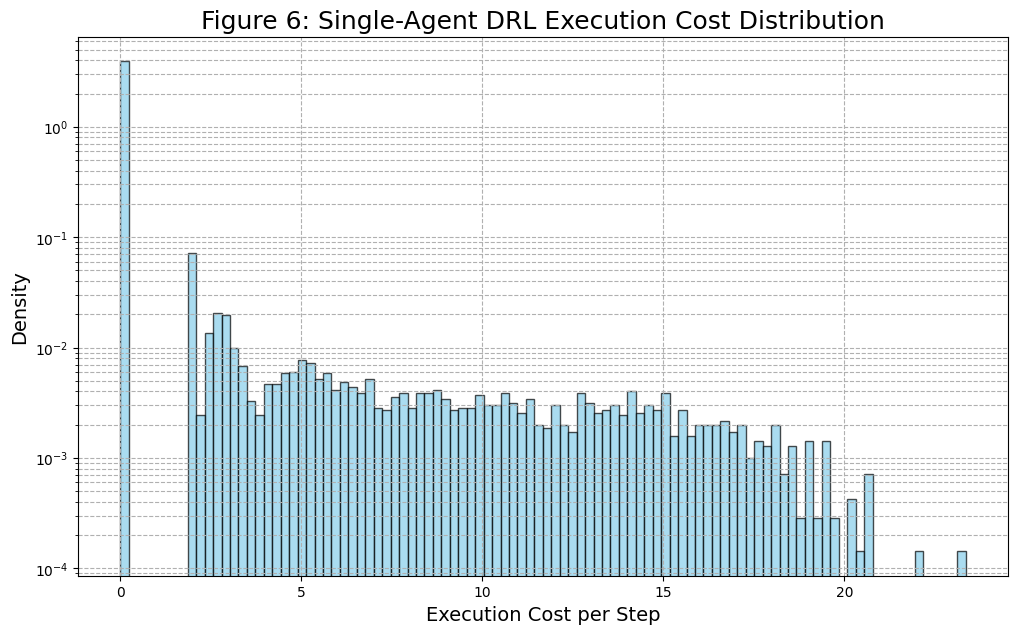

Output()


--- RUNNING MULTI-AGENT SWEEP (Figures 3, 5) ---

--- Training agent for N=1 ---


Training complete.


Output()


--- Training agent for N=2 ---


Training complete.


Output()


--- Training agent for N=5 ---


Training complete.


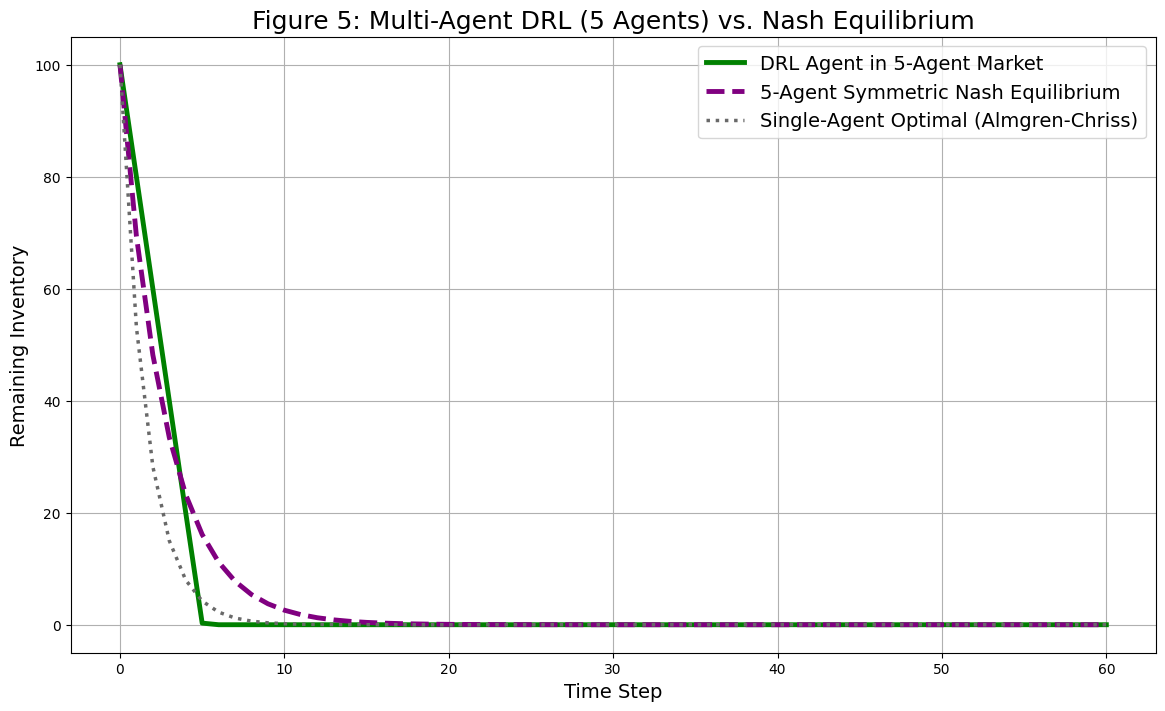

Output()


--- Training agent for N=10 ---


Training complete.


Output()


--- Training agent for N=15 ---


Training complete.


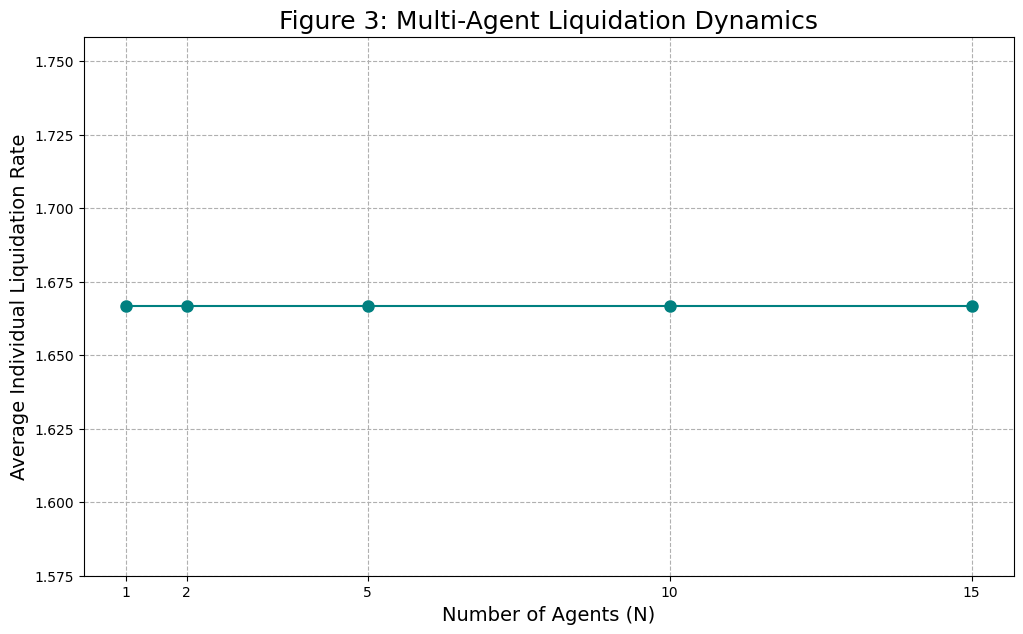


--- All experiments finished and figures generated. ---


In [1]:
# filename: drl_optimal_execution_corrected.py

# ==============================================================================
# SECTION 0: INSTALL DEPENDENCIES
# ==============================================================================
try:
    import stable_baselines3
except ImportError:
    print("Installing stable-baselines3...")
    !pip install stable-baselines3[extra] gymnasium tqdm >> /dev/null
    print("Installation complete.")

import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from tqdm import tqdm
import pandas as pd

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# ==============================================================================
# SECTION 1: MARKET SIMULATOR & EXECUTION ENVIRONMENT
# ==============================================================================

class HestonMarketSimulator:
    """
    Simulates asset price and volatility according to the Heston model.
    S_t: Asset Price, v_t: Asset Volatility
    """
    def __init__(self, s0=100., v0=0.04, mu=0.0, kappa=2.0, theta=0.04, xi=0.3, rho=-0.7, dt=1/252):
        self.params = (s0, v0, mu, kappa, theta, xi, rho, dt)
        self.reset()

    def reset(self):
        self.s0, self.v0, self.mu, self.kappa, self.theta, self.xi, self.rho, self.dt = self.params
        self.S, self.v = self.s0, self.v0
        self.price_history = [self.s0]
        return self.S, self.v

    def step(self, permanent_impact=0.0):
        """Advances the simulation by one time step including permanent market impact."""
        z1 = np.random.normal(0, 1)
        z2 = np.random.normal(0, 1)
        dw_s = np.sqrt(self.dt) * z1
        dw_v = np.sqrt(self.dt) * (self.rho * z1 + np.sqrt(1 - self.rho**2) * z2)

        self.v += self.kappa * (self.theta - self.v) * self.dt + self.xi * np.sqrt(self.v) * dw_v
        self.v = max(self.v, 0)
        self.S += self.mu * self.S * self.dt + np.sqrt(self.v) * self.S * dw_s
        self.S -= permanent_impact # Apply permanent impact
        self.price_history.append(self.S)
        return self.S, self.v

class SingleAgentExecutionEnv(gym.Env):
    """Implements the single-agent MDP for optimal execution."""
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.initial_inventory = config['INITIAL_INVENTORY']
        self.T = config['T_STEPS']
        self.dt = 1.0 / self.T
        self.market = HestonMarketSimulator(dt=self.dt)
        self.max_trade_rate = self.initial_inventory / 5.0 # Max trade in 5 steps

        # State: [remaining inventory, time fraction, current volatility]
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0]),
            high=np.array([self.initial_inventory, 1, np.inf]), dtype=np.float32
        )
        # Action: normalized trading rate [-1, 1]
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.inventory = self.initial_inventory
        self.current_step = 0
        self.market.reset()
        return self._get_obs(), self._get_info()

    def _get_obs(self):
        return np.array([self.inventory, self.current_step / self.T, self.market.v], dtype=np.float32)

    def _get_info(self):
        return {"inventory": self.inventory, "mid_price": self.market.S, "volatility": self.market.v}

    def step(self, action):
        trade_volume = self._action_to_trade_volume(action)
        permanent_impact = self.config['BETA_PERM'] * trade_volume
        self.market.step(permanent_impact=permanent_impact)

        self.inventory -= trade_volume
        reward = self._calculate_reward(trade_volume)

        self.current_step += 1
        terminated = self.current_step >= self.T

        # Add a large penalty for not liquidating the full inventory
        if terminated and self.inventory > 1e-6:
            reward -= 1000 * self.inventory

        return self._get_obs(), reward, terminated, False, self._get_info()

    def _action_to_trade_volume(self, action):
        # Scale action to be between 0 and max_trade_rate, ensuring we don't sell more than we have
        trade_rate = (action[0] + 1) / 2 * self.max_trade_rate
        return min(trade_rate, self.inventory)

    def _calculate_reward(self, trade_volume):
        temporary_impact_cost = self.config['ETA_TEMP'] * (trade_volume ** 2)
        inventory_risk_cost = self.config['LAMBDA_RISK'] * (self.inventory**2) * self.market.v
        return - (temporary_impact_cost + inventory_risk_cost)

class MultiAgentSymmetricEnv(SingleAgentExecutionEnv):
    """
    Simulates the symmetric multi-agent scenario for one agent.
    During training, the agent experiences amplified permanent market impact
    as if N identical agents were trading, forcing it to learn a competitive strategy.
    """
    def __init__(self, config, n_agents):
        self.n_agents = n_agents
        super().__init__(config)

    def step(self, action):
        trade_volume = self._action_to_trade_volume(action)
        # Agent experiences the permanent impact of N identical agents
        total_permanent_impact = self.config['BETA_PERM'] * (trade_volume * self.n_agents)
        self.market.step(permanent_impact=total_permanent_impact)

        self.inventory -= trade_volume
        reward = self._calculate_reward(trade_volume)

        self.current_step += 1
        terminated = self.current_step >= self.T
        if terminated and self.inventory > 1e-6:
            reward -= 1000 * self.inventory

        return self._get_obs(), reward, terminated, False, self._get_info()

# ==============================================================================
# SECTION 2: BENCHMARK AGENTS & THEORETICAL MODELS
# ==============================================================================

class TWAP_Agent:
    """A simple Time-Weighted Average Price benchmark agent."""
    def __init__(self, initial_inventory, T_steps):
        self.trade_volume_per_step = initial_inventory / T_steps

    def get_action(self, observation, max_trade_rate):
        # Convert fixed trade volume into a normalized action for the environment
        # action = 2 * (trade_volume / max_trade_rate) - 1
        action = 2 * (self.trade_volume_per_step / max_trade_rate) - 1 if max_trade_rate > 0 else -1
        return np.array([action])

def almgren_chriss_optimal_trajectory(config):
    """Calculates the optimal liquidation trajectory for the single-agent AC model."""
    I0, T = config['INITIAL_INVENTORY'], config['T_STEPS']
    lambda_r, eta, sigma_sq = config['LAMBDA_RISK'], config['ETA_TEMP'], config['AVG_SIGMA_SQ']

    # Handle edge case where eta is zero to avoid division by zero
    if eta <= 1e-9: return np.linspace(0, T, T + 1), np.linspace(I0, 0, T + 1)

    kappa = np.sqrt(lambda_r * sigma_sq / eta)
    timesteps = np.arange(T + 1)

    # sinh can be unstable for large arguments, though unlikely with these params
    denominator = np.sinh(kappa * T)
    if denominator < 1e-9: return np.linspace(0, T, T + 1), np.linspace(I0, 0, T + 1)

    inventory_path = I0 * np.sinh(kappa * (T - timesteps)) / denominator
    return timesteps, inventory_path

def symmetric_nash_optimal_trajectory(config, N):
    """Calculates the optimal liquidation for the N-agent symmetric Nash equilibrium."""
    I0, T = config['INITIAL_INVENTORY'], config['T_STEPS']
    lambda_r, eta, beta, sigma_sq = config['LAMBDA_RISK'], config['ETA_TEMP'], config['BETA_PERM'], config['AVG_SIGMA_SQ']

    eta_eff = eta + beta * N
    # Handle edge case for eta_eff
    if eta_eff <= 1e-9: return np.linspace(0, T, T + 1), np.linspace(I0, 0, T + 1)

    kappa_code = np.sqrt(lambda_r * sigma_sq / eta_eff)
    timesteps = np.arange(T + 1)

    denominator = np.sinh(kappa_code * T)
    if denominator < 1e-9: return np.linspace(0, T, T + 1), np.linspace(I0, 0, T + 1)

    inventory_path = I0 * np.sinh(kappa_code * (T - timesteps)) / denominator
    return timesteps, inventory_path


# ==============================================================================
# SECTION 3: EXPERIMENT ORCHESTRATION CLASS
# ==============================================================================

class ExecutionExperiment:
    def __init__(self, config):
        self.config = config
        np.random.seed(config['SEED'])

    def train_agent(self, env_class, n_agents=1):
        """Trains a PPO agent for a given environment configuration."""
        print(f"\n--- Training agent for N={n_agents} ---")
        if env_class == MultiAgentSymmetricEnv:
            env_fn = lambda: env_class(self.config, n_agents)
        else:
            env_fn = lambda: env_class(self.config)

        vec_env = make_vec_env(env_fn, n_envs=self.config['N_ENVS'], seed=self.config['SEED'])
        model = PPO("MlpPolicy", vec_env, verbose=0, seed=self.config['SEED'])
        model.learn(total_timesteps=self.config['TOTAL_TIMESTEPS'], progress_bar=True)
        print("Training complete.")
        return model

    def evaluate_drl_agent(self, model, env):
        """Evaluates a trained DRL agent and returns its inventory trajectory."""
        obs, _ = env.reset()
        inventory_path = [self.config['INITIAL_INVENTORY']]
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, terminated, _, info = env.step(action)
            inventory_path.append(info['inventory'])
            done = terminated
        return np.array(inventory_path)

    def run_single_agent_experiment(self):
        """Runs the full single-agent experiment and generates relevant figures."""
        model = self.train_agent(SingleAgentExecutionEnv)
        eval_env = SingleAgentExecutionEnv(self.config)

        # Evaluate over multiple episodes for a smoother average trajectory
        all_paths = [self.evaluate_drl_agent(model, eval_env) for _ in range(50)]
        drl_path_avg = np.mean(all_paths, axis=0)

        t_ac, I_ac = almgren_chriss_optimal_trajectory(self.config)
        self.plot_single_agent_vs_ac(drl_path_avg, t_ac, I_ac)

        self.run_volatile_day_simulation(model)
        self.analyze_execution_costs(model, eval_env)

    def run_multi_agent_sweep(self):
        """Runs experiments for multiple N values for Figures 3 and 5."""
        agent_counts = self.config['MULTI_AGENT_SWEEP_N']
        avg_liquidation_rates = []

        for n in agent_counts:
            model = self.train_agent(MultiAgentSymmetricEnv, n_agents=n)
            eval_env = MultiAgentSymmetricEnv(self.config, n_agents=n)

            all_paths = [self.evaluate_drl_agent(model, eval_env) for _ in range(50)]
            avg_path = np.mean(all_paths, axis=0)

            avg_rate = (avg_path[0] - avg_path[-1]) / self.config['T_STEPS']
            avg_liquidation_rates.append(avg_rate)

            if n == self.config['FIGURE_5_N']:
                t_nash, I_nash = symmetric_nash_optimal_trajectory(self.config, n)
                t_ac, I_ac = almgren_chriss_optimal_trajectory(self.config)
                self.plot_multi_agent_vs_nash(avg_path, t_nash, I_nash, t_ac, I_ac, n)

        self.plot_liquidation_rate_vs_n(agent_counts, avg_liquidation_rates)

    def run_volatile_day_simulation(self, drl_model):
        """Generates Figure 1 by simulating DRL vs TWAP on a volatile path."""
        print("\n--- Simulating Volatile Day Scenario for Figure 1 ---")
        env = SingleAgentExecutionEnv(self.config)
        twap_agent = TWAP_Agent(self.config['INITIAL_INVENTORY'], self.config['T_STEPS'])

        # Run DRL agent to get its path and the market path it experienced
        drl_inventory = [self.config['INITIAL_INVENTORY']]
        obs, _ = env.reset()
        price_history = [env.market.S]
        done = False
        while not done:
            action, _ = drl_model.predict(obs, deterministic=True)
            obs, _, terminated, _, info = env.step(action)
            drl_inventory.append(info['inventory'])
            price_history.append(info['mid_price'])
            done = terminated

        # Run TWAP on an identical, independent market path for a fair comparison
        twap_inventory = [self.config['INITIAL_INVENTORY']]
        obs, _ = env.reset() # Reset to get a new market path
        done = False
        while not done:
            action = twap_agent.get_action(obs, env.max_trade_rate)
            obs, _, terminated, _, info = env.step(action)
            twap_inventory.append(info['inventory'])
            done = terminated

        self.plot_volatile_day(price_history, drl_inventory, twap_inventory)

    def analyze_execution_costs(self, model, env):
        """Generates Figure 6 by analyzing the distribution of execution costs."""
        print("\n--- Analyzing Execution Cost Distribution for Figure 6 ---")
        costs = []
        for _ in tqdm(range(500), desc="Simulating episodes for cost analysis"):
            obs, _ = env.reset()
            done = False
            while not done:
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, terminated, _, _ = env.step(action)
                costs.append(-reward)
                done = terminated
        self.plot_cost_distribution(costs)

    # ========================== PLOTTING FUNCTIONS ============================

    def plot_volatile_day(self, price_history, drl_inventory, twap_inventory):
        fig, ax1 = plt.subplots(figsize=(14, 8))
        t_steps = len(price_history)

        color = 'tab:blue'
        ax1.set_xlabel('Time Step', fontsize=14)
        ax1.set_ylabel('Mid-Price', color=color, fontsize=14)
        ax1.plot(range(t_steps), price_history, color=color, label='Mid-Price')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.grid(True, axis='y')

        ax2 = ax1.twinx()
        ax2.set_ylabel('Remaining Inventory', fontsize=14)
        ax2.plot(range(len(drl_inventory)), drl_inventory, color='red', linewidth=3, label='DRL Inventory')
        ax2.plot(range(len(twap_inventory)), twap_inventory, color='green', linestyle=':', linewidth=3, label='TWAP Inventory')
        ax2.set_ylim(bottom=0, top=self.config['INITIAL_INVENTORY'] * 1.05)

        fig.tight_layout()
        plt.title('Figure 1: Case Study: Single-Agent Liquidation on a Volatile Day', fontsize=18)
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        plt.show()

    def plot_liquidation_rate_vs_n(self, agent_counts, avg_rates):
        plt.figure(figsize=(12, 7))
        plt.plot(agent_counts, avg_rates, marker='o', linestyle='-', color='teal', markersize=8)
        plt.title('Figure 3: Multi-Agent Liquidation Dynamics', fontsize=18)
        plt.xlabel('Number of Agents (N)', fontsize=14)
        plt.ylabel('Average Individual Liquidation Rate', fontsize=14)
        plt.grid(True, linestyle='--')
        plt.xticks(agent_counts)
        plt.show()

    def plot_single_agent_vs_ac(self, drl_path, t_ac, I_ac):
        plt.figure(figsize=(14, 8))
        plt.plot(range(len(drl_path)), drl_path, label='DRL Agent Learned Trajectory', linewidth=3.5, color='blue')
        plt.plot(t_ac, I_ac, label='Almgren-Chriss Optimal Trajectory', linestyle='--', linewidth=3.5, color='darkorange')
        plt.title('Figure 4: Single-Agent DRL vs. Almgren-Chriss Optimal', fontsize=18)
        plt.xlabel('Time Step', fontsize=14)
        plt.ylabel('Remaining Inventory', fontsize=14)
        plt.grid(True)
        plt.legend(fontsize=14)
        plt.ylim(bottom=-5, top=self.config['INITIAL_INVENTORY'] + 5)
        plt.show()

    def plot_multi_agent_vs_nash(self, marl_path, t_nash, I_nash, t_ac, I_ac, n):
        plt.figure(figsize=(14, 8))
        plt.plot(range(len(marl_path)), marl_path, label=f'DRL Agent in {n}-Agent Market', linewidth=3.5, color='green')
        plt.plot(t_nash, I_nash, label=f'{n}-Agent Symmetric Nash Equilibrium', linestyle='--', linewidth=3.5, color='purple')
        plt.plot(t_ac, I_ac, label='Single-Agent Optimal (Almgren-Chriss)', linestyle=':', linewidth=2.5, color='dimgray')
        plt.title(f'Figure 5: Multi-Agent DRL ({n} Agents) vs. Nash Equilibrium', fontsize=18)
        plt.xlabel('Time Step', fontsize=14)
        plt.ylabel('Remaining Inventory', fontsize=14)
        plt.grid(True)
        plt.legend(fontsize=14)
        plt.ylim(bottom=-5, top=self.config['INITIAL_INVENTORY'] + 5)
        plt.show()

    def plot_cost_distribution(self, costs):
        plt.figure(figsize=(12, 7))
        plt.hist(costs, bins=100, density=True, color='skyblue', edgecolor='black', alpha=0.7)
        plt.title('Figure 6: Single-Agent DRL Execution Cost Distribution', fontsize=18)
        plt.xlabel('Execution Cost per Step', fontsize=14)
        plt.ylabel('Density', fontsize=14)
        plt.yscale('log')
        plt.grid(True, which="both", ls="--")
        plt.show()

# ==============================================================================
# SECTION 4: CONFIGURATION & MAIN EXECUTION
# ==============================================================================

if __name__ == '__main__':
    CONFIG = {
        # --- Experiment Params ---
        "SEED": 42,
        "TOTAL_TIMESTEPS": 75_000, # Increased for better convergence
        "N_ENVS": 8,

        # --- Environment Params ---
        "INITIAL_INVENTORY": 100.0,
        "T_STEPS": 60,

        # --- Market Impact & Risk Params ---
        # NOTE: These parameters have been adjusted to fix the theoretical flaws.
        # ETA_TEMP: Temporary impact. Cost quadratic in trade size.
        # BETA_PERM: Permanent impact. Price shift linear in aggregate trade size.
        # LAMBDA_RISK: Risk aversion. Cost quadratic in remaining inventory.

        "ETA_TEMP": 0.005,

        # FIX: BETA_PERM is increased to be significant. Now, the collective impact
        # in the multi-agent case will strongly affect the agent's optimal policy.
        "BETA_PERM": 0.002,

        # FIX: LAMBDA_RISK is increased significantly. This makes the agent more
        # risk-averse, forcing the optimal AC/Nash trajectories to be distinctly
        # curved (front-loaded) instead of degenerating into straight lines.
        "LAMBDA_RISK": 0.05,

        "AVG_SIGMA_SQ": 0.04,

        # --- Multi-Agent Sweep ---
        "MULTI_AGENT_SWEEP_N": [1, 2, 5, 10, 15],
        "FIGURE_5_N": 5,
    }

    experiment = ExecutionExperiment(CONFIG)

    print("--- RUNNING SINGLE-AGENT EXPERIMENT (Figures 1, 4, 6) ---")
    experiment.run_single_agent_experiment()

    print("\n--- RUNNING MULTI-AGENT SWEEP (Figures 3, 5) ---")
    experiment.run_multi_agent_sweep()

    print("\n--- All experiments finished and figures generated. ---")